In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Import tsv data with header
df = pd.read_csv('data/final_datasets/aggregated_dataset.tsv', sep=';')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
# Create week column
df['week'] = pd.to_datetime(df['date']).dt.week
# Make week 52 to 0
df['week'] = df['week'].replace(52, 0)

<ipython-input-6-6f8e0d800fdd>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = pd.to_datetime(df['date']).dt.week


In [7]:
df.head()

,date,corpus,text_type,conflict,similarity,knowledge,power,status,support,identity,romance,trust,fun,High,Low,Mean,event_id,event_type,period_type,week
0,2022-03-06,sarn sauron coin bsc gem of 2022 launch now e...,post,0.217982,0.008616,0.987545,0.095460,0.210643,0.012049,0.401652,0.004092,8.436824e-07,0.404854,39640.176751,38211.647962,38925.912357,1.0,positive,before,9
1,2022-03-06,a proposal to you removed,post,0.503045,0.435572,0.485023,0.518171,0.427520,0.495435,0.432057,0.254124,3.306695e-01,0.453298,39640.176751,38211.647962,38925.912357,1.0,positive,before,9
2,2022-03-06,time to buy nan,post,0.315845,0.453668,0.491014,0.467255,0.453663,0.485220,0.443327,0.571401,4.674791e-01,0.595824,39640.176751,38211.647962,38925.912357,1.0,positive,before,9
3,2022-03-06,stupid question please excuse my ignorance can...,post,0.685344,0.003814,0.995469,0.033478,0.095750,0.000713,0.207318,0.000114,8.855732e-07,0.099581,39640.176751,38211.647962,38925.912357,1.0,positive,before,9
4,2022-03-06,bitcoin nan,post,0.488357,0.469591,0.483014,0.434496,0.515467,0.484323,0.482162,0.507920,5.038089e-01,0.523179,39640.176751,38211.647962,38925.912357,1.0,positive,before,9


In [27]:
def calculate_zscore(df, dimension, threshold = 0.5):
    f_scores = [] 
    # iterate over each week 
    for week in sorted(df['week'].unique()):

        # Count how many texts exceeds the threshold
        n_wihtin_dim = df[(df['week'] == week) & (df[dimension] > threshold)].shape[0]
        # Compute the fraction of texts that exceed the threshold
        f = n_wihtin_dim / df[df['week'] == week].shape[0]
        # Append the fraction to the list
        f_scores.append((week, f))

    # Compute the mean and standard deviation of the fractions
    mean = np.mean([f[1] for f in f_scores])
    std = np.std([f[1] for f in f_scores])

    # Compute the z-scores
    z_scores = [(f[0], (f[1] - mean) / std) for f in f_scores]
    return z_scores  

In [45]:
# Create a new dataframe with z-scores
z_scores = pd.DataFrame(columns = df.columns[3:13], index = sorted(df['week'].unique()))

for dimension in df.columns[3:13]:
    z_s = calculate_zscore(df, dimension)
    z_scores[dimension] = [z[1] for z in z_s]


In [60]:
# Make a date column from week index in the z-scores dataframe
import datetime
mondays = [datetime.datetime.strptime("2022-W" + str(int(w)) + '-1', "%Y-W%W-%w").date() for w in z_scores.index]
sundays = [datetime.datetime.strptime("2022-W" + str(int(w)) + '-0', "%Y-W%W-%w").date() for w in z_scores.index]
z_scores['date'] = [str(m) + ' - ' + str(s) for m, s in zip(mondays, sundays)]

,conflict,similarity,knowledge,power,status,support,identity,romance,trust,fun,date
0,-3.013080,0.063347,2.611241,-4.293999,0.058754,2.233962,-3.528539,-2.176769,0.492573,-2.195353,2021-12-27 - 2022-01-02
1,0.860803,1.281931,-0.164164,0.159261,0.718849,0.102100,-1.537784,1.673250,-1.311629,1.789169,2022-01-03 - 2022-01-09
2,0.359675,0.964453,-0.108456,0.342983,0.011036,0.550980,-0.336582,-0.504367,-0.533733,-0.156614,2022-01-10 - 2022-01-16
3,-0.267622,0.156060,-0.052747,-0.483769,-0.539485,0.415381,-0.413129,-0.791526,0.605815,0.188681,2022-01-17 - 2022-01-23
4,1.672259,0.278441,-0.853189,0.319249,0.184885,-0.681962,0.851603,-0.756261,-0.824636,0.154299,2022-01-24 - 2022-01-30


In [87]:
events = df[["date","event_type","period_type", "event_id"]].drop_duplicates().dropna()
# Group by event_type, period_type and event_id and make a date range

hep = events.groupby(["event_type","period_type", "event_id"]).agg({"date": [min, max]}).reset_index()
# make min and max date
hep["min_date"] = pd.to_datetime(hep["date"]["min"])
hep["max_date"] = pd.to_datetime(hep["date"]["max"])

# make a date range
hep["date_range"] = hep.apply(lambda x: str(x["min_date"].date()) + " - " +  str(x["max_date"].date())), axis=1)


# remove date, min_date and max_date columns
#hep = hep.drop(["date", "min_date", "max_date"], axis=1)
#print(hep)


In [91]:
print(hep["min_date"][0].date())

<class 'datetime.date'>


# Aske with rolling average

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import dtale
import numpy as np

In [180]:
# Import threshold data from data/annotation/thresholds.json 
thresholds = pd.read_json('data/annotation/new_thresholds.json', orient='index')
# Rename column as threshold
thresholds = thresholds.rename(columns={0: 'threshold'})

thresholds.head(10)

,threshold
conflict,0.818478
similarity,0.854911
knowledge,0.555801
power,0.944096
status,0.547299
support,0.508339
identity,0.506308
romance,0.816755
trust,0.585201
fun,0.714779


In [181]:
num_days_rolling_average = 7

# Load in the aggregated dataset 
dataset_raw = pd.read_csv('data/final_datasets/aggregated_dataset.tsv',sep=';')

# Select subset of columns
dataset = dataset_raw[['date','High','Low','Mean','event_id','event_type','period_type']].drop_duplicates()

# Initialize dimensions 
dims = ['conflict','similarity','knowledge','power','status','support','identity','romance','trust','fun']

# Initialize dictionary with eventtype dataframes
corr_dfs = {}

# Events with no overlapping events as it complicates the analysis
events = dataset_raw[["date","event_type","period_type", "event_id"]].drop_duplicates(subset=["date"], keep="first").fillna("no_event")

/var/folders/ks/84b6fb594mg0n57lspnlf0nm0000gn/T/ipykernel_37475/284661519.py:4: DtypeWarning:

Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.



In [88]:
dataset_onehot = dataset_raw.copy()

# Iterate over dimensions and binarize based on the threshold defined in the top (for Bence)
for dim in dims:
    # Index threshold from thresholds dataframe
    threshold = thresholds.loc[dim]['threshold']
    # Overwrites each dimension with a binary value
    dataset_onehot[dim] = dataset_onehot[dim].apply(lambda x:1  if x>threshold else 0)

In [93]:
# Count number of scores above threshold for each day for each dimension
posts_per_day = dataset_onehot.groupby(['date']).sum()
# Remove columns that are not dimensions
posts_per_day = posts_per_day.drop(['High','Low','Mean','event_id', "romance"], axis=1)

/var/folders/ks/84b6fb594mg0n57lspnlf0nm0000gn/T/ipykernel_37475/1098897421.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<AxesSubplot: xlabel='date'>

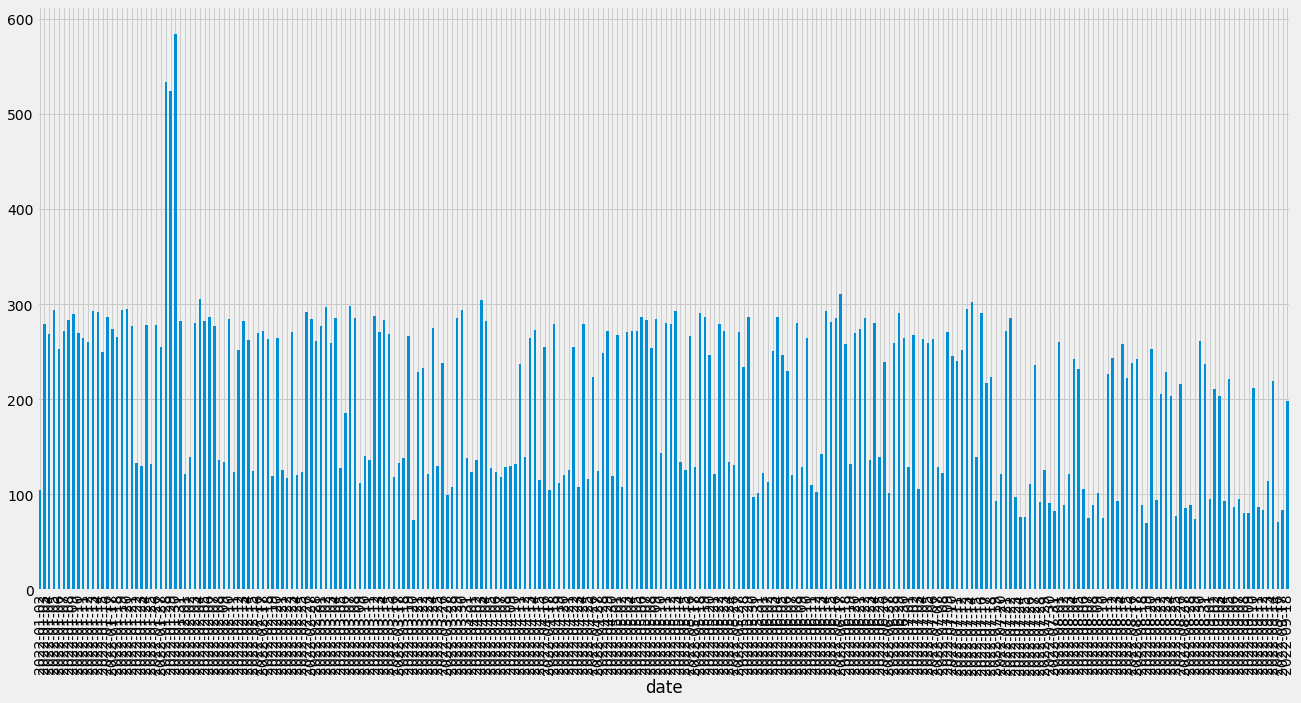

In [100]:
# Plot posts per day for knowledge as a bar chart
posts_per_day['support'].plot(kind='bar', figsize=(20,10))


In [101]:
# Group event posts by date (summed)
# Basically assigns a count of posts containing a given dimension for each day
cols = ['date']+dims+['Mean']
dataset_onehot = dataset_onehot[cols].groupby('date').mean().sort_index()


In [70]:
dataset_onehot.head()

,conflict,similarity,knowledge,power,status,support,identity,romance,trust,fun,Mean
date,,,,,,,,,,,
2022-01-02,0.342697,0.494382,0.544944,0.455056,0.331461,0.589888,0.567416,0.0,0.421348,0.573034,47369.171271
2022-01-03,0.447500,0.647500,0.417500,0.575000,0.440000,0.697500,0.597500,0.0,0.490000,0.637500,46673.344600
2022-01-04,0.510000,0.672500,0.407500,0.592500,0.447500,0.672500,0.620000,0.0,0.500000,0.597500,46579.505932
2022-01-05,0.457500,0.717500,0.377500,0.612500,0.467500,0.735000,0.657500,0.0,0.550000,0.572500,44863.635027
2022-01-06,0.480000,0.695000,0.437500,0.537500,0.380000,0.632500,0.647500,0.0,0.475000,0.575000,43197.130631


In [102]:
# Apply rolling average, essentially, iterating over the days,
# taking the average over the previous 3 days and 3 next days
# and assigning this value
# The first and last 3 days will be empty as they don't have enough preceding og succeeding days. 
#### These days are dropped
dataset_out = dataset_onehot.rolling(num_days_rolling_average,center=True).mean().dropna().sort_index()

# Create standard deviation dataframe for each dimension
dataset_out_sd = dataset_onehot.rolling(num_days_rolling_average,center=True).std().dropna().sort_index()

# Iterating over the dimensions, calculating the mean and std in order to calculate the z-score
# z_score(x) = (x-mean(X))/std(X)
for dim in dims:
    # Get mu and std
    mu = dataset_out[dim].mean()
    std = dataset_out[dim].std()
    # Get mu and std for standard deviation dataframe
    mu_sd = dataset_out_sd[dim].mean()
    std_sd = dataset_out_sd[dim].std()

    # Check if any values over the threshold for a dimension - if not we would accidentally divide by zero
    # Only an issue for identity
    if std:
        # Calculate z-score and overwrite value for each dimension
        dataset_out[dim] = dataset_out[dim].apply(lambda x: (x-mu)/std)
        # Calculate z-score for standard deviation dataframe
        dataset_out_sd[dim] = dataset_out_sd[dim].apply(lambda x: (x-mu_sd)/std_sd)
        
    else:
        # Drop empty dimensions
        dataset_out.drop(dim,axis=1,inplace=True)
        dataset_out_sd.drop(dim,axis=1,inplace=True)
        print('Dropping',dim)

# Merge with standard deviation dataframe
dataset_out = dataset_out.merge(dataset_out_sd, on='date', suffixes=('', '_sd'), how='left')

# Merge with posts per day dataframe
dataset_out = dataset_out.merge(posts_per_day, on='date', suffixes=('', '_n_posts'), how='left')

# Merge with event data
dataset_out = dataset_out.merge(events, on='date', how='left')

Dropping romance


In [103]:
dataset_out.head()

,date,conflict,similarity,knowledge,power,status,support,identity,trust,fun,...,knowledge_n_posts,power_n_posts,status_n_posts,support_n_posts,identity_n_posts,trust_n_posts,fun_n_posts,event_type,period_type,event_id
0,2022-01-05,0.306578,0.563582,0.548996,-1.812011,-0.428710,-0.248404,-1.450585,-0.791976,1.271589,...,151,245,187,294,263,220,229,no_event,no_event,no_event
1,2022-01-06,1.164938,1.630658,-0.800789,-0.822685,0.242076,0.552270,-1.018225,0.051714,1.632834,...,175,215,152,253,259,190,230,no_event,no_event,no_event
2,2022-01-07,1.466845,1.630658,-0.656131,-0.942133,-0.149343,0.418935,-0.793700,-0.033575,1.399646,...,173,228,160,272,240,181,240,no_event,no_event,no_event
3,2022-01-08,1.118491,1.559714,-0.398960,-1.078644,-0.608836,0.359675,-0.949140,-0.170037,1.224755,...,144,240,147,283,247,199,262,no_event,no_event,no_event
4,2022-01-09,1.037208,1.074933,0.002869,-1.505243,-1.017274,-0.144033,-1.398190,-0.767060,1.428794,...,134,240,172,290,252,218,254,no_event,no_event,no_event


# Plotting for periods

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# Load the z_score dataset
dataset = pd.read_csv('data/final_datasets/FINAL_zscores.tsv',sep=';')

In [183]:
dataset.head()

,date,conflict,similarity,knowledge,power,status,support,identity,romance,trust,...,knowledge_n_posts,power_n_posts,status_n_posts,support_n_posts,identity_n_posts,trust_n_posts,fun_n_posts,event_type,period_type,event_id
0,2022-01-05,0.020890,2.569153,-0.613984,-1.404718,1.303257,0.869050,-1.869442,0.184201,-1.108175,...,242,11,20,57,12,64,25,0,0,0
1,2022-01-06,0.011768,2.201146,-1.426388,-1.537249,0.667011,0.129951,-1.230260,0.876489,-1.307047,...,269,9,24,42,21,52,27,0,0,0
2,2022-01-07,0.377078,2.331634,-1.426388,-1.689447,0.474406,0.129951,-0.615008,0.184201,-1.256836,...,265,9,19,42,12,42,38,0,0,0
3,2022-01-08,0.377078,2.462123,-1.095138,-1.080658,0.715162,0.218010,-0.425699,0.530345,-1.206624,...,243,11,23,40,18,56,34,0,0,0
4,2022-01-09,0.092948,2.375131,-0.752465,-1.080658,1.004070,-0.280990,-0.283718,0.530345,-1.357259,...,230,5,16,31,18,55,25,0,0,0


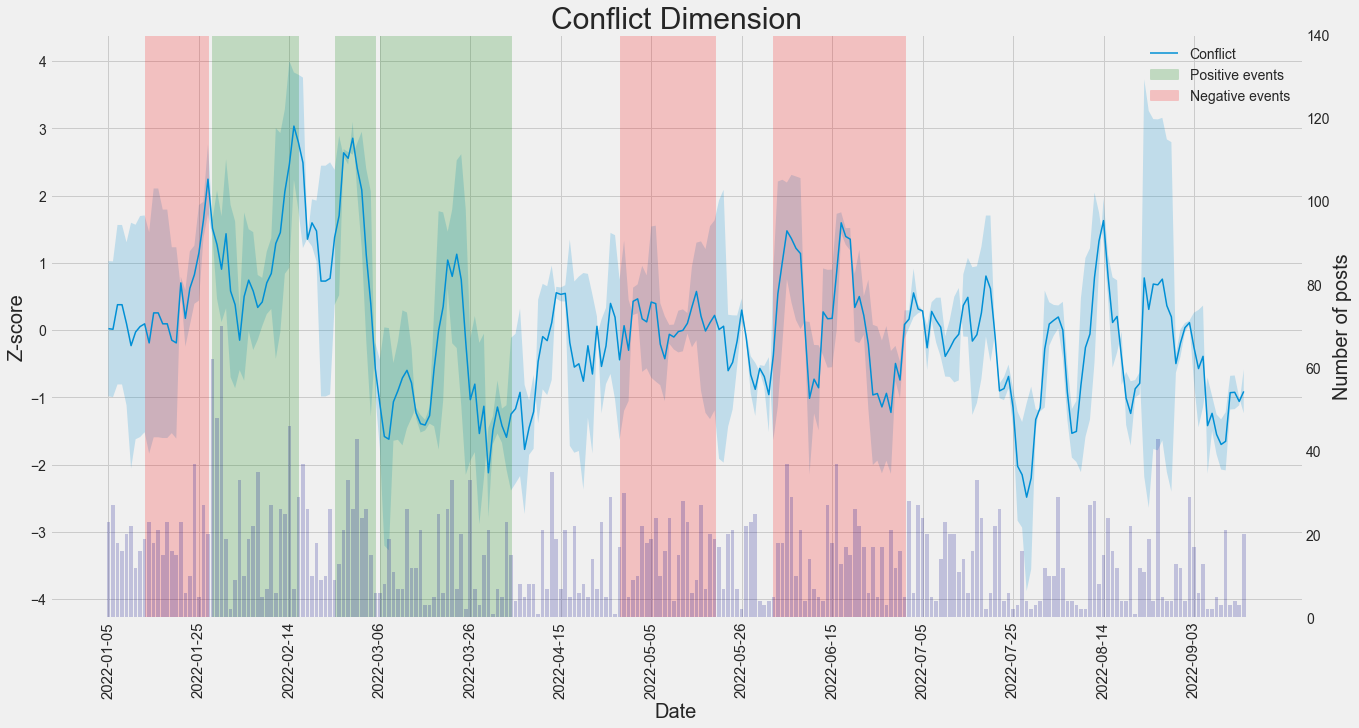

In [186]:
# Function for plotting a dimension
def plot_dim(dim):
    # Initialize figure
    plt.figure(figsize=(20,10))
    # Set style
    plt.style.use("fivethirtyeight")
    
    # Plot the dimension
    plt.plot(dataset['date'],dataset[dim], linewidth= 1.5, label = dim[0].upper() + dim[1:])
    

    # Plot the standard deviation as a shaded area
    min_val = dataset[dim] - dataset[dim+'_sd']
    max_val = dataset[dim] + dataset[dim+'_sd']
    plt.fill_between(dataset['date'], min_val, max_val, alpha=0.2)

    # Make the plot readable
    plt.xticks(rotation=90)
    # Make x-axis ticks every 20 days
    plt.xticks(np.arange(0, len(dataset['date']), 20), size = 15)

    # Visualize event id 1, 2 and 3 as x-span
    for event_id in [1,2,3]:
        # Get the min and max date for the event
        min_date = dataset[(dataset['event_id']==event_id)]['date'].min()
        max_date = dataset[(dataset['event_id']==event_id)]['date'].max()
        if event_id == 1:
            # Plot the x-span
            plt.axvspan(min_date, max_date, color='green', alpha=0.2, label = "Positive events")
        else:
            # Plot the x-span
            plt.axvspan(min_date, max_date, color='green', alpha=0.2)

    # Visualize event id 4, 5 and 6 as x-span
    for event_id in [4,5,6]:
        # Get the min and max date for the event
        min_date = dataset[(dataset['event_id']==event_id)]['date'].min()
        max_date = dataset[(dataset['event_id']==event_id)]['date'].max()
        
        if event_id == 4:
            # Plot the x-span
            plt.axvspan(min_date, max_date, color='red', alpha=0.2, label = "Negative events")
        else:
            # Plot the x-span
            plt.axvspan(min_date, max_date, color='red', alpha=0.2)

    # Create legend with positve and negative events 
    plt.legend()

    # Make x and y axis labels
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Z-score", fontsize=20)

    # Add second y-axis for number of posts as bar chart
    plt.twinx()
    plt.bar(dataset['date'], dataset[dim+'_n_posts'], alpha=0.2, label = "Number of posts", color='darkblue')
    plt.ylabel("Number of posts", fontsize=20)
    # Make y-axis twice as big as the other
    plt.gca().set_ylim(bottom=0, top=dataset[dim+'_n_posts'].max()*2)
    # Remove gridlines of second y-axis
    plt.grid(False)
    # Move ticks so they align with the other y-axis
    plt.gca().yaxis.set_ticks_position('right')
    




    # Create title with dim and bigger font
    plt.title(dim[0].upper() + dim[1:] + " Dimension", fontsize=30)
    plt.show()
    # Save figure
    #plt.savefig('viz/dimension_plots/z_score_'+dim+'.png')

plot_dim('conflict')

In [143]:
dataset.event_id.value_counts()

0    125
1     30
4     30
5     22
2     20
6     15
3     10
Name: event_id, dtype: int64

TypeError: plot got an unexpected keyword argument 'x'

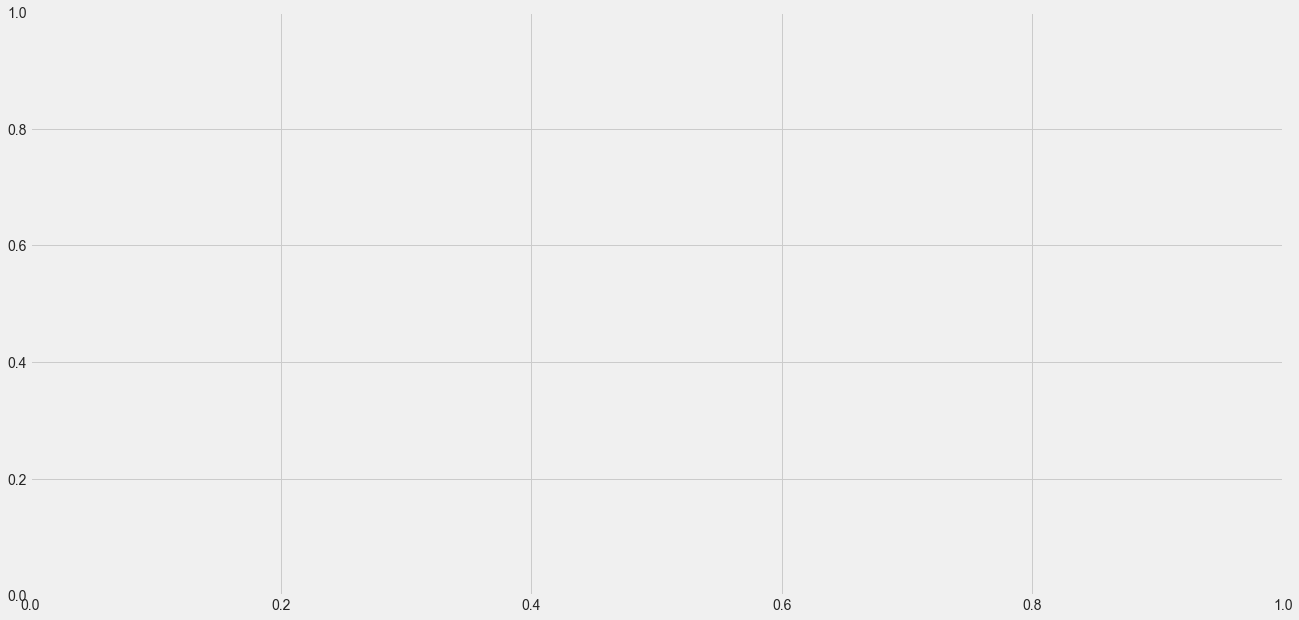

In [164]:
# Function for plotting a dimension
def plot_dim(dim):

    plt.figure(figsize=(20,10))
    plt.style.use('fivethirtyeight')

    # Plot every event id
    for event in range(7):
        if event == 0:
            color = "blue"
            plt.plot(dataset=dataset[dataset['event_id']==event], x='date', y=dim, linewidth= 1.5, color = color, label = "Event " + str(event))
        elif event in [1,2,3]:
            color = "green"
            plt.plot(dataset=dataset[dataset['event_id']==event], x='date', y=dim, linewidth= 1.5, color = color)
        elif event in [4,5,6]:
            color = "red"
            plt.plot(dataset=dataset[dataset['event_id']==event], x='date', y=dim, linewidth= 1.5, color = color)
    
    # Make the plot readable
    plt.xticks(rotation=90)
    # Make x-axis ticks every 20 days
    plt.xticks(np.arange(0, len(dataset['date']), 20), size = 15)



plot_dim('knowledge')

In [ ]:
dims = ['conflict','similarity','knowledge','power','status','support','romance','trust','fun']
# Plot dimensions side by side
for dim in dims:
    plot_dim(dim)
#plot_dim('conflict')

In [ ]:
# dimension columns
dims = ['conflict','similarity','knowledge','power','status','support','romance','trust','fun']